In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)

In [90]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

from sklearn import preprocessing

from sklearn.metrics import mean_squared_error
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score

from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
#from sklearn.svm import SVC
from sklearn.linear_model import LinearRegression, Ridge, ElasticNet
from sklearn.linear_model import LogisticRegression

from sklearn.ensemble import RandomForestClassifier

from sklearn.impute import SimpleImputer as Imputer

from sklearn.pipeline import Pipeline

In [81]:
def dropthenan(table):
    cond1 = table[table.cfbconference == 'Other'].index.tolist()
    cond2 = table[table.cfbtd.isna()].index.tolist()
    cond3 = table[table.combineforty.isna()].index.tolist()
#    cond = np.unique(cond1+cond2+cond3)
    cond = np.intersect1d(np.intersect1d(cond1,cond2),cond3)
    return table.drop(cond, axis = 0).reset_index(drop = True)

def confclass(table):
    table.loc[table.cfbconference == 'Other','cfbconference'] = np.nan
    table.loc[table.cfbclass == 'Non Declared','cfbclass'] = np.nan
    table = pd.get_dummies(table, prefix=['cfbconference','cfbclass'])
    return table

# def splitter(table, col, thresh):
#     table['target'] = table[col].apply(lambda x: 1 if x > thresh else 0)
#     return table.drop(col, axis = 1)

def splitter(arr, thresh):
    return arr.apply(lambda x: 1 if x > thresh else 0)

def normalizeX(X, cols_list):
    x = X[cols_list]
    X_others = X.drop(cols_list, axis = 1)
    trans = preprocessing.MinMaxScaler()
    #trans = preprocessing.StandardScaler()
    x_scaled = trans.fit_transform(x)
    X_new = pd.DataFrame(x_scaled , columns = X[cols_list].columns.tolist())
    return pd.concat([X_new, X_others], axis = 1) #pd.concat([X_new + X_others], axis = 1)

In [6]:
colsnum = ['cfbgames','cfbreceptions','cfbrecyards','cfbrecyardsperreception','cfbrectd',
           'cfbrushattempts','cfbrushyards','cfbrushyardsperattempt','cfbrushtd','cfbscrimmages',
           'cfbyards','cfbyardsfromscrimmage','cfbtd','combineht','combinewt','combineforty',
           'combinevertical','combinebroadjump','combinecone','combineshuttle']

wr = pd.read_csv('data_sets/wr.csv')
wr = wr.rename(columns = {'yardsfirst5seasons': 'yffs'})
wr = wr.drop('combinebenchreps', axis = 1)

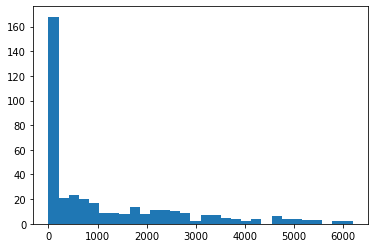

In [225]:
plt.hist(wrp.yffs, bins = 30)
plt.show()

# At a fixed threshold y < or > 50

In [82]:
wr1 = dropthenan(wr)
wr1 = confclass(wr1)

In [83]:
X = wr1.drop('yffs', axis = 1)
y = wr1.yffs

imp = Imputer(missing_values= np.nan, strategy = 'mean')
imp.fit(X)
X = imp.transform(X)
X = pd.DataFrame(X, columns = wr1.drop('yffs', axis = 1).columns.tolist())

X = normalizeX(X, colsnum)
y = splitter(y, 50)

### KNeighbors Classifier on a random train/test split data

In [84]:
knn = KNeighborsClassifier(n_neighbors = 18)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .30, stratify = y)

knn.fit(X_train,y_train)
y_pred = knn.predict(X_test)

print('score',knn.score(X_test, y_test))
# print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

score 0.6964285714285714
              precision    recall  f1-score   support

           0       0.40      0.19      0.26        31
           1       0.74      0.89      0.81        81

    accuracy                           0.70       112
   macro avg       0.57      0.54      0.53       112
weighted avg       0.65      0.70      0.66       112



### Logistic Regression on a random train/test split data

In [85]:
logreg = LogisticRegression()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .30, stratify = y)

logreg.fit(X_train,y_train)

y_pred = logreg.predict(X_test)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[ 5 26]
 [ 5 76]]
              precision    recall  f1-score   support

           0       0.50      0.16      0.24        31
           1       0.75      0.94      0.83        81

    accuracy                           0.72       112
   macro avg       0.62      0.55      0.54       112
weighted avg       0.68      0.72      0.67       112



### ROC Curve (varying threshold p) on a random train/test split data

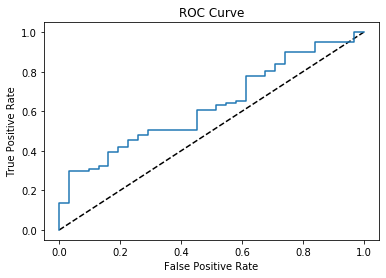

0.6284348864994026


In [86]:
logreg = LogisticRegression()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .30, stratify = y)

logreg.fit(X_train,y_train)

y_pred_prob = logreg.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

print(roc_auc_score(y_test, y_pred_prob))

### Hyperparameter tuning the KNeighbors Classifier using the GridSearchCV

In [87]:
param_grid = {'n_neighbors':np.arange(1, 50)}
knn = KNeighborsClassifier()
knn_cv = GridSearchCV(knn, param_grid, cv = 10)

knn_cv.fit(X, y)

print(knn_cv.best_params_)
print(knn_cv.best_score_)

{'n_neighbors': 43}
0.7239687055476529


### Using a Pipeline to for Hyperparameter tuning on  a Logisitic Regressor and a Random Forest Classifier

In [138]:
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .30, stratify = y)
pipeline = Pipeline([('classifier' , RandomForestClassifier())])

# param_grid = [
#     {'classifier' : [LogisticRegression()],
#      'classifier__penalty' : ['l1', 'l2'],
#     'classifier__C' : np.logspace(-5, 8, 15),
#     'classifier__solver' : ['liblinear']},
#     {'classifier' : [RandomForestClassifier()],
#     'classifier__n_estimators' : list(range(10,101,10)),
#     'classifier__max_features' : list(range(6,32,5))}
# ]


param_grid =  {'classifier' : [RandomForestClassifier()],
    'classifier__n_estimators' : list(range(10,101,10)),
    'classifier__max_features' : list(range(6,32,5))}

clf = GridSearchCV(pipeline, param_grid = param_grid, cv = 5, verbose=True, n_jobs=-1)

best_clf = clf.fit(X, y)

Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    4.5s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   26.8s finished


In [140]:
#print(best_clf)
#print("Best params", best_clf.best_params_)
print("Best score", best_clf.best_score_)
for param_name in sorted(param_grid.keys()):
    print("%s: %s" %(param_name, best_clf.best_params_[param_name]))

Best score 0.7346306306306307
classifier: RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features=6,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=70,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)
classifier__max_features: 6
classifier__n_estimators: 70


In [141]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .30, stratify = y)

y_pred = best_clf.predict(X_test)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[31  0]
 [ 0 81]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        31
           1       1.00      1.00      1.00        81

    accuracy                           1.00       112
   macro avg       1.00      1.00      1.00       112
weighted avg       1.00      1.00      1.00       112



In [110]:
# param_grid = {'C': np.logspace(-5, 8, 15),'penalty': ['l1', 'l2']}
# logreg = LogisticRegression()
# logreg_cv = GridSearchCV(logreg, param_grid, cv=5, verbose=0)

# logreg_cv.fit(X, y)

# print("Tuned Logistic Regression Parameters: {}".format(logreg_cv.best_params_)) 
# print("Best score is {}".format(logreg_cv.best_score_))

# # print('Best Penalty:', best_model.best_estimator_.get_params()['penalty'])
# # print('Best C:', best_model.best_estimator_.get_params()['C'])

# Varying Threshold of Acceptance

In [30]:
wr2 = dropthenan(wr)
wr2 = confclass(wr2)
X = wr2.drop('yffs', axis = 1)

imp = Imputer(missing_values= np.nan, strategy = 'mean')
imp.fit(X)
X = imp.transform(X)
X = pd.DataFrame(X, columns = wr1.drop('yffs', axis = 1).columns.tolist())

X = normalizeX(X, colsnum)
#y = wr2.yffs
#y = splitter(y, 50)

### With a KNeighbors Classifier

In [31]:
param_grid = {'n_neighbors':np.arange(1,30)}
knn = KNeighborsClassifier()
knn_cv = GridSearchCV(knn, param_grid, cv = 10)

bp_list=[]
bs_list=[]

for thresh in np.arange(1,100,5):
    y = wr2.yffs
    y = splitter(y, thresh)
    knn_cv.fit(X, y)
    bp_list.append(knn_cv.best_params_)
    bs_list.append(knn_cv.best_score_)

### With a Random Forest Classifier (using a Pipeline)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .30, stratify = y)

pipeline = Pipeline([('classifier' , RandomForestClassifier())])
param_grid =  {'classifier' : [RandomForestClassifier()],
    'classifier__n_estimators' : list(range(10,101,10)),
    'classifier__max_features' : list(range(6,32,5))}
clf = GridSearchCV(pipeline, param_grid = param_grid, cv = 5, verbose=True, n_jobs=-1)

best_clf = clf.fit(X_train, y_train)

y_pred = best_clf.predict(X_test)




In [ ]:
# First Model: X, y < 10
alpha_space = np.logspace(-4, 0, 50)
param_grid = {'alpha': alpha_space}

ridge = Ridge(normalize = True)
reg_cv = GridSearchCV(ridge, param_grid, cv=10, scoring= 'neg_root_mean_squared_error', refit = False)
reg_cv.fit(X, y)

print("Tuned Linear Regression Parameters: {}".format(reg_cv.best_params_)) 
print("Best score is {}".format(-reg_cv.best_score_))
alpha_best = reg_cv.best_params_['alpha']

ridge_rmse = []
for alpha in alpha_space:
    ridge.alpha = alpha   
    ridge_cv_scores = cross_validate(ridge, X, y, cv = 10, scoring=('r2', 'neg_root_mean_squared_error'))   
    ridge_rmse.append(-np.mean(ridge_cv_scores['test_neg_root_mean_squared_error']))
    
plt.plot(alpha_space, ridge_rmse)
plt.xscale("log")
plt.xlabel("Alpha")
plt.ylabel('Root Mean Square Error')
plt.axvline(alpha_best, linestyle = '--')
plt.axhline(-reg_cv.best_score_, linestyle = '--')
plt.show()